In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import mixture
from scipy.stats import t
import warnings
from scipy.stats import mode
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def flip_if_needed(labels):
    if np.sum(labels == 0) > np.sum(labels == 1):
        return 1 - labels
    return labels

def accuracy(true_labels, predicted_labels):
    return np.sum(true_labels == predicted_labels) / len(true_labels)

dimensions = [2]
datasets = []

clustering_algorithms = [
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
    mixture.BayesianGaussianMixture(n_components=2, covariance_type="full")
]

lettered_models_to_model_name= {"KMeans": "(b) K-Means", "AgglomerativeClustering": "(c) Agglomerative Clustering",
                      "DBSCAN": "(d) DBSCAN", "BayesianGaussianMixture": "(e) BGMM"}
models_to_model_name= {"KMeans": "K-Means", "AgglomerativeClustering": "Agglomerative Clustering",
                      "DBSCAN": "DBSCAN", "BayesianGaussianMixture": "BGMM"}
model_name_to_models = {
 'K-Means': 'KMeans',
 'Agglomerative Clustering': 'AgglomerativeClustering',
 'DBSCAN': 'DBSCAN',
 'BGMM': 'BayesianGaussianMixture'
}

accuracy_table_general = {'Data': [], 'Algorithm': [], 'Accuracy': []}

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode

def get_accuracy_and_plot_clusters(datasets, filename, lim_list):
    plt.figure(figsize=(15, 4 * len(dimensions)))
    accuracy_table_general = {'Data': [], 'Algorithm': [], 'Accuracy': []}

    # Define the consistent color for the background points from 'viridis' colormap
    background_color = plt.cm.viridis(0)  # Adjust the value as needed to get the dark purple color
    
    # Define the color for the largest cluster using the end of the 'viridis' colormap
    largest_cluster_color = plt.cm.viridis(255) 

    subplot_labels = 'abcde'  # Extend this as needed
    label_index = 0
    for idx, (data, labels, data_name) in enumerate(datasets):
        for algorithm in clustering_algorithms:
            algorithm_name = lettered_models_to_model_name[algorithm.__class__.__name__]
            labels = flip_if_needed(labels)
            cluster_labels = flip_if_needed(algorithm.fit_predict(data))

            # Identify the largest cluster
            if np.any(cluster_labels == -1):  # DBSCAN might label noise as -1
                cluster_labels_no_noise = cluster_labels[cluster_labels != -1]
                largest_cluster = mode(cluster_labels_no_noise).mode[0] if cluster_labels_no_noise.size > 0 else -1
            else:
                largest_cluster = mode(cluster_labels).mode[0]

            # Plot the original labels
            ax = plt.subplot(len(dimensions), len(clustering_algorithms) + 1, idx * (len(clustering_algorithms) + 1) + 1)
            ax.set_aspect('equal', 'datalim')
            ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', s=0.5)  # Smaller points with s=0.5
            ax.set_xticks(lim_list, fontsize=14)
            ax.set_yticks(lim_list, fontsize=14)
            ax.set_title(data_name, fontsize=14)

            # Plot the cluster labels
            ax = plt.subplot(len(dimensions), len(clustering_algorithms) + 1, idx * (len(clustering_algorithms) + 1) + clustering_algorithms.index(algorithm) + 2)
            ax.set_aspect('equal', 'datalim')

            # Plot all other points first using the consistent background color from 'viridis'
            other_points = cluster_labels != largest_cluster
            ax.scatter(data[other_points, 0], data[other_points, 1], c=[background_color], marker='o', s=0.5, alpha=0.5)

            # Plot the largest cluster (if you have a specific color for this, set it here)
            largest_cluster_points = cluster_labels == largest_cluster
            ax.scatter(data[largest_cluster_points, 0], data[largest_cluster_points, 1], c=largest_cluster_color, marker='o', s=0.5)
            ax.set_xticks(lim_list, fontsize=14)
            ax.set_yticks(lim_list, fontsize=14)

            ax.set_title(f"{algorithm_name}", fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)

            acc = accuracy(labels, cluster_labels)
            accuracy_table_general['Data'].append(data_name)
            accuracy_table_general['Algorithm'].append(algorithm_name)
            accuracy_table_general['Accuracy'].append(acc)

    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=600)
    plt.show()
    accuracy_df_general = pd.DataFrame(accuracy_table_general)
    return accuracy_df_general

In [4]:
# Define necessary functions
def generate_normal_data(n_samples, n_features, mean=0, std_dev=1, random_state=None):
    np.random.seed(random_state)
    return np.random.normal(mean, std_dev, size=(n_samples, n_features))

def generate_dependent_normal_data(n_samples, n_features, mean=None, std_dev=None, correlation=0.5, random_state=None):
    """Generate multi-dimensional normal distributed data with dependencies."""
    np.random.seed(random_state)
    
    if mean is None:
        mean = np.zeros(n_features)
    
    if std_dev is None:
        std_dev = np.ones(n_features)
    
    # Check the consistency of provided mean and std_dev
    assert len(mean) == n_features, f"Expected mean of length {n_features}, but got {len(mean)}"
    assert len(std_dev) == n_features, f"Expected std_dev of length {n_features}, but got {len(std_dev)}"
    
    # Create a correlation matrix
    corr_matrix = np.full((n_features, n_features), correlation)
    np.fill_diagonal(corr_matrix, 1.0)
    
    # Convert the correlation matrix to a covariance matrix
    cov_matrix = np.outer(std_dev, std_dev) * corr_matrix
    
    return np.random.multivariate_normal(mean, cov_matrix, n_samples)

def generate_t_data(n_samples, n_features, df=10, loc=0, scale=1, random_state=None):
    """Generate multi-dimensional t-distributed data."""
    np.random.seed(random_state)
    return t.rvs(df=df, loc=loc, scale=scale, size=(n_samples, n_features))

def generate_chi2_data(n_samples, n_features, df, scale=1, random_state=None):
    """Generate multi-dimensional chi-square distributed data."""
    np.random.seed(random_state)
    data = np.sqrt(np.random.chisquare(df=df, size=(n_samples, n_features))) * scale
    return data

def generate_weibull_data(n_samples, n_features, shape=1, scale=1, random_state=None):
    np.random.seed(random_state)
    return np.random.weibull(a=shape, size=(n_samples, n_features)) * scale

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

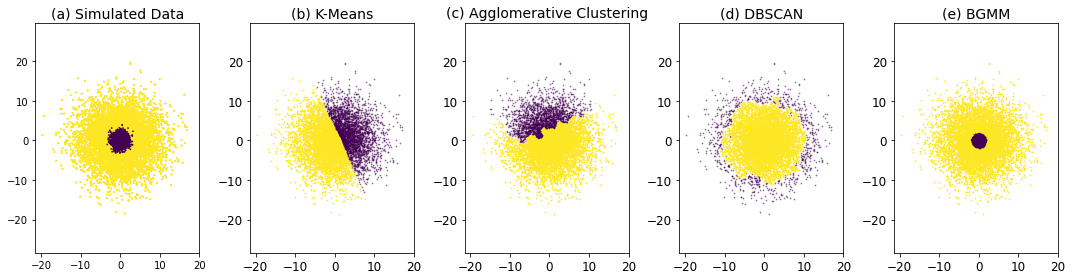

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.4534
1  (a) Simulated Data  (c) Agglomerative Clustering    0.5066
2  (a) Simulated Data                    (d) DBSCAN    0.6203
3  (a) Simulated Data                      (e) BGMM    0.9048


In [5]:
# Scenario 1: two independent normal distributions

datasets = []

for dim in dimensions:
    data_large = generate_normal_data(n_samples=7000, n_features=dim, mean=0, std_dev=5, random_state=42)
    data_small = generate_normal_data(n_samples=3000, n_features=dim, mean=0, std_dev=1, random_state=42)
    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario1", [-20.0, -10.0, 0.0, 10.0, 20.0])
print(accuracy_df_general)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

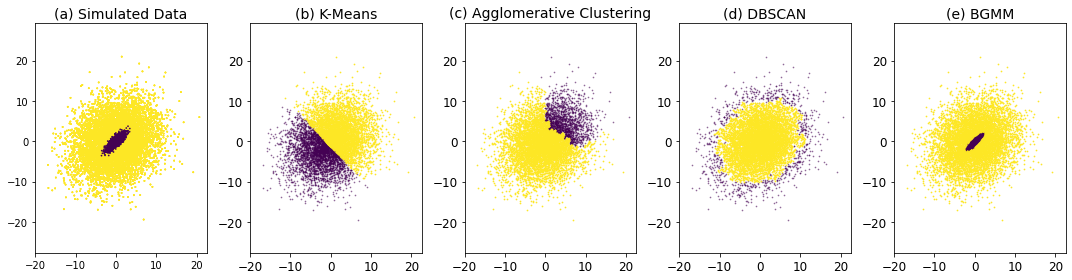

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.4712
1  (a) Simulated Data  (c) Agglomerative Clustering    0.5537
2  (a) Simulated Data                    (d) DBSCAN    0.6221
3  (a) Simulated Data                      (e) BGMM    0.9325


In [6]:
# Scenario 2: two dependent normal distributions

datasets = []

for dim in dimensions:
    # Mean and standard deviation for data_large
    mean_large = np.zeros(dim)
    std_dev_large = 5 * np.ones(dim)
    
    # Mean and standard deviation for data_small
    mean_small = np.zeros(dim)
    std_dev_small = np.ones(dim)
    
    data_large = generate_dependent_normal_data(n_samples=7000, n_features=dim, mean=mean_large, std_dev=std_dev_large, correlation=0.2)
    data_small = generate_dependent_normal_data(n_samples=3000, n_features=dim, mean=mean_small, std_dev=std_dev_small, correlation=0.8)
    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario2", [-20.0, -10.0, 0.0, 10.0, 20.0])
print(accuracy_df_general)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

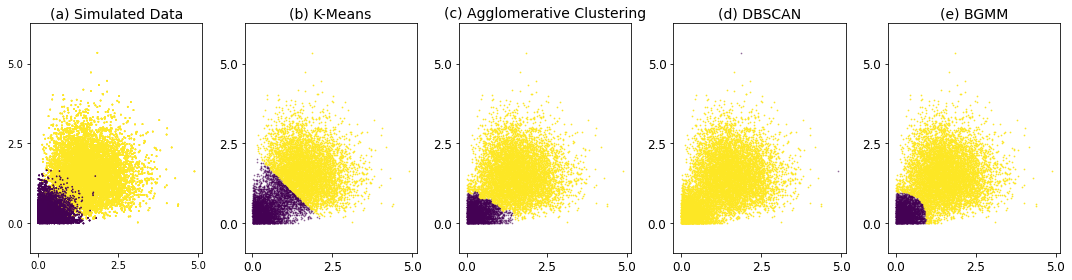

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.8818
1  (a) Simulated Data  (c) Agglomerative Clustering    0.9551
2  (a) Simulated Data                    (d) DBSCAN    0.6998
3  (a) Simulated Data                      (e) BGMM    0.9488


In [7]:
# Scenario 3: two chi-squared distributions

datasets = []

for dim in dimensions:
    data_large = generate_chi2_data(n_samples=7000, n_features=dim, df=3, scale=1, random_state=0)
    data_small = generate_chi2_data(n_samples=3000, n_features=dim, df=1, scale=0.5, random_state=1)
    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario3", [0.0, 2.5, 5.0])
print(accuracy_df_general)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

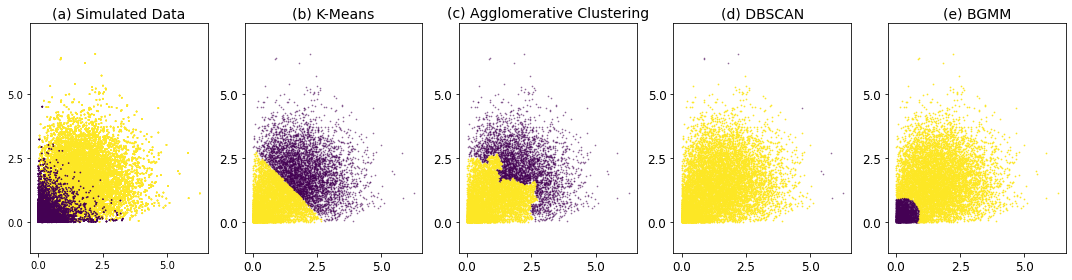

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.2382
1  (a) Simulated Data  (c) Agglomerative Clustering    0.3495
2  (a) Simulated Data                    (d) DBSCAN    0.6990
3  (a) Simulated Data                      (e) BGMM    0.8893


In [8]:
# Scenario 4: two weibull distributions
datasets = []

for dim in dimensions:
    data_large = generate_weibull_data(n_samples=7000, n_features=dim, shape=2, scale=2, random_state=0)
    data_small = generate_weibull_data(n_samples=3000, n_features=dim, shape=1, scale=0.5, random_state=1)

    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario4", [0.0, 2.5, 5.0])
print(accuracy_df_general)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

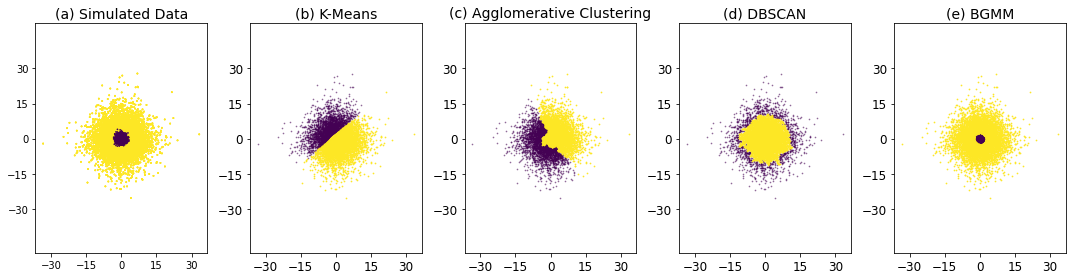

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.4494
1  (a) Simulated Data  (c) Agglomerative Clustering    0.3977
2  (a) Simulated Data                    (d) DBSCAN    0.5799
3  (a) Simulated Data                      (e) BGMM    0.9066


In [9]:
# Scenario 5: t-distribution and normal distribution

datasets = []

for dim in dimensions:
    # Use t-distribution for data_large
    data_large = generate_t_data(n_samples=7000, n_features=dim, loc=0, scale=5, random_state=0)
    # Keep data_small as standard normal distribution
    data_small = generate_normal_data(n_samples=3000, n_features=dim, random_state=1)
    
    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario5", [-30.0, -15.0, 0.0, 15.0, 30.0])
print(accuracy_df_general)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

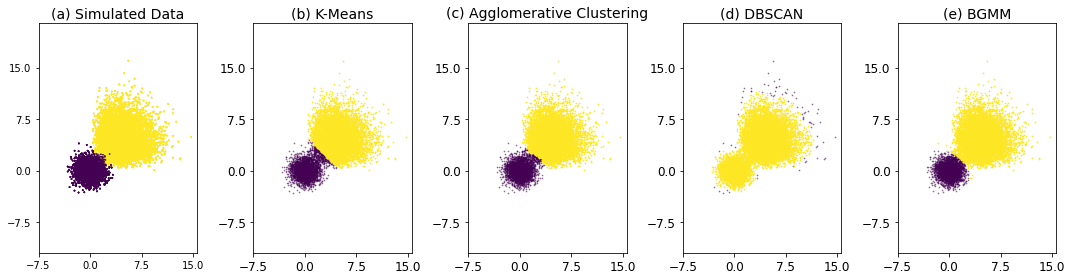

                 Data                     Algorithm  Accuracy
0  (a) Simulated Data                   (b) K-Means    0.9667
1  (a) Simulated Data  (c) Agglomerative Clustering    0.9829
2  (a) Simulated Data                    (d) DBSCAN    0.6938
3  (a) Simulated Data                      (e) BGMM    0.9926


In [10]:
# Scenario 6: One chi-squared and one normal distribution
datasets = []

for dim in dimensions:
    data_large = generate_chi2_data(n_samples=7000, n_features=dim, df=3, scale=3, random_state=0)
    data_small = generate_normal_data(n_samples=3000, n_features=dim, random_state=1)

    data = np.concatenate((data_large, data_small), axis=0)
    labels = np.concatenate((np.zeros(data_large.shape[0]), np.ones(data_small.shape[0])))
    datasets.append((data, labels, "(a) Simulated Data"))

accuracy_df_general = get_accuracy_and_plot_clusters(datasets, "scenario6", [-7.5, 0.0, 7.5, 15.0])
print(accuracy_df_general)